In [3]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import lib.general_utilities as gu

# storing data directories for this notebook.
img_out_dir = 'data/images/LDA_analysis_NB5/'
data_out_dir = 'data/pickled/LDA_analysis_NB5/'

%matplotlib inline

In [19]:
filename = 'data/processed_dataset_df/airline_proc_dataset_70percCL_withEmEnc_df'
air_df = gu.read_pickle_obj(filename)

In [20]:
air_df.columns

Index(['airline', 'airline_sentiment', 'text', 'clean_text',
       'stopw_clean_text', 'stem_stopw_clean_text', 'emojis', 'negativereason',
       'airline_sentiment_confidence'],
      dtype='object')

In [21]:
air_df.shape

(10768, 9)

In [22]:
air_df[['clean_text','stopw_clean_text', 'stem_stopw_clean_text']][:11]

clean_text  \
0                                           what said   
1   its really aggressive to blast obnoxious enter...   
2             and its a really big bad thing about it   
3   seriously would pay 30 a flight for seats that...   
4   it was amazing and arrived an hour early youre...   
5   i lt3 pretty graphics so much better than mini...   
6   this is such a great deal already thinking abo...   
7                                              thanks   
8   so excited for my first cross country flight l...   
9   i flew from nyc to sfo last week and couldnt f...   
10               i  EMOJI_1️ flying  EMOJI_2️ EMOJI_3   

                                     stopw_clean_text  \
0                                                said   
1   really aggressive blast obnoxious entertainmen...   
2                                really big bad thing   
3   seriously pay 30 seats didnt playing really ba...   
4               amazing arrived hour early youre good   
5    lt3 pretty graphics better minimal iconography d   
6   great deal thinking 2nd trip havent gone 1st t...   
7                                              thanks   
8   excited cross country lax mco ive heard great ...   
9   flew nyc sfo week fully sit seat large gentlem...   
10                   EMOJI_1️ flying EMOJI_2️ EMOJI_3   

                                stem_stopw_clean_text  
0                                                said  
1   realli aggress blast obnoxi entertain guest fa...  
2                                realli big bad thing  
3   serious pay 30 seat didnt play realli bad thin...  
4                     amaz arriv hour earli your good  
5       lt3 pretti graphic better minim iconographi d  
6    great deal think 2nd trip havent gone 1st trip p  
7                                               thank  
8   excit cross countri lax mco ive heard great th...  
9   flew nyc sfo week fulli sit seat larg gentlema...  
10                      emoji_1️ fli emoji_2️ emoji_3

In [11]:
#!pip install gensim

In [23]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string

In [24]:
import nltk

In [25]:
# load stopwords and exclude punctuation sets.
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

In [26]:
def tokenize(text):
    return(text.split())

In [27]:
def process_doc(text):
    
    rem_stop = " ".join([i for i in text.lower().split() if i not in stop])
    rem_punc= ''.join(ch for ch in rem_stop if ch not in exclude)
    text = " ".join(lemma.lemmatize(word) for word in rem_punc.split())
    
    return(text)

In [28]:
# Corpus of documents, each doc is a tweet. 
# I used stemming earlier, where it finds the stem of the words by truncating the ends.
# Lemmatization is a more elegant way of doing this 'normalization". It finds the root of
# the word.
air_df['lemma_stopw_clean_text'] = air_df['clean_text'].apply(process_doc)

In [17]:
air_df[['clean_text', 'stem_stopw_clean_text', 'lemma_stopw_clean_text']][:15]

clean_text  \
0                                           what said   
1   its really aggressive to blast obnoxious enter...   
2             and its a really big bad thing about it   
3   seriously would pay 30 a flight for seats that...   
4   it was amazing and arrived an hour early youre...   
5   i lt3 pretty graphics so much better than mini...   
6   this is such a great deal already thinking abo...   
7                                              thanks   
8   so excited for my first cross country flight l...   
9   i flew from nyc to sfo last week and couldnt f...   
10               i  EMOJI_1️ flying  EMOJI_2️ EMOJI_3   
11  you know what would be amazingly awesome bosfl...   
12                                i love this graphic   
13  i love the hipster innovation you are a feel g...   
14  will you be making bosgtlas non stop permanent...   

                                stem_stopw_clean_text  \
0                                                said   
1   realli aggress blast obnoxi entertain guest fa...   
2                                realli big bad thing   
3   serious pay 30 seat didnt play realli bad thin...   
4                     amaz arriv hour earli your good   
5       lt3 pretti graphic better minim iconographi d   
6    great deal think 2nd trip havent gone 1st trip p   
7                                               thank   
8   excit cross countri lax mco ive heard great th...   
9   flew nyc sfo week fulli sit seat larg gentlema...   
10                      emoji_1️ fli emoji_2️ emoji_3   
11              know amazingli awesom bosfll want fli   
12                                       love graphic   
13                 love hipster innov feel good brand   
14           make bosgtla non stop perman anytim soon   

                               lemma_stopw_clean_text  
0                                                said  
1   really aggressive blast obnoxious entertainmen...  
2                                really big bad thing  
3   seriously would pay 30 flight seat didnt playi...  
4               amazing arrived hour early youre good  
5   lt3 pretty graphic much better minimal iconogr...  
6   great deal already thinking 2nd trip amp haven...  
7                                              thanks  
8   excited first cross country flight lax mco ive...  
9   flew nyc sfo last week couldnt fully sit seat ...  
10                      emoji1️ flying emoji2️ emoji3  
11  know would amazingly awesome bosfll please wan...  
12                                       love graphic  
13            love hipster innovation feel good brand  
14  making bosgtlas non stop permanently anytime soon

In [29]:
# pickle this dataframe that has an added column with 'lemmatized' text.
filename = 'data/processed_dataset_df/airline_proc_dataset_70percCL_withEmEnc_addLemma_df'
gu.pickle_obj(filename, air_df)

## Gensim LDA

In [98]:
doc_clean = air_df['lemma_stopw_clean_text']
# Corpus is in string format and doc2bow array expects tokens. Let's tokenize doc strings.
doc_clean = doc_clean.apply(tokenize)
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(doc_clean)
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [155]:
corpora.MmCorpus.serialize('corpus.mm', doc_term_matrix)

In [174]:
# Creating the object for LDA model.
Lda = LdaModel

In [175]:
lda_model = Lda(doc_term_matrix, num_topics=10, id2word = dictionary, passes=50)

In [176]:
# Running and Trainign LDA model on the document term matrix.
lda_model = Lda(doc_term_matrix, num_topics=10, id2word = dictionary)

In [177]:
# Pickle lda model.
gu.pickle_obj(data_out_dir+'lda_transf.obj', Lda)

# Pickle lda dictionary.
gu.pickle_obj(data_out_dir+'lda_dictionary.obj', dictionary)

# Pickle lda transformed corpus.
gu.pickle_obj(data_out_dir+'lda_model.obj', lda_model)

In [4]:
lda_model = gu.read_pickle_obj(data_out_dir+'lda_model.obj')

In [5]:
print(lda_model.print_topics(num_topics=10, num_words=10))

[(0, '0.010*"customer" + 0.009*"service" + 0.009*"dont" + 0.009*"like" + 0.008*"u" + 0.007*"fly" + 0.007*"im" + 0.007*"staff" + 0.007*"want" + 0.007*"people"'), (1, '0.070*"flight" + 0.029*"hour" + 0.014*"delayed" + 0.013*"plane" + 0.013*"late" + 0.013*"get" + 0.011*"ive" + 0.011*"2" + 0.010*"cancelled" + 0.008*"time"'), (2, '0.049*"flight" + 0.022*"u" + 0.019*"cancelled" + 0.014*"weather" + 0.012*"im" + 0.010*"get" + 0.009*"flighted" + 0.007*"time" + 0.007*"home" + 0.007*"hour"'), (3, '0.034*"call" + 0.021*"thanks" + 0.018*"phone" + 0.018*"help" + 0.017*"service" + 0.016*"customer" + 0.013*"cant" + 0.013*"thank" + 0.013*"response" + 0.011*"back"'), (4, '0.018*"flight" + 0.014*"get" + 0.012*"bag" + 0.010*"baggage" + 0.010*"dfw" + 0.010*"time" + 0.009*"hour" + 0.009*"plane" + 0.009*"airport" + 0.008*"day"'), (5, '0.047*"flight" + 0.040*"cancelled" + 0.030*"flightled" + 0.025*"aa" + 0.021*"hold" + 0.021*"get" + 0.020*"help" + 0.015*"cant" + 0.012*"tomorrow" + 0.012*"call"'), (6, '0.024*"

In [7]:
topics_df = pd.DataFrame(lda_model.print_topics(num_topics=10, num_words=10))

In [8]:
topics_df.drop(0, axis = 1, inplace=True)

In [10]:
topics_df[:15]

1
0  0.010*"customer" + 0.009*"service" + 0.009*"do...
1  0.070*"flight" + 0.029*"hour" + 0.014*"delayed...
2  0.049*"flight" + 0.022*"u" + 0.019*"cancelled"...
3  0.034*"call" + 0.021*"thanks" + 0.018*"phone" ...
4  0.018*"flight" + 0.014*"get" + 0.012*"bag" + 0...
5  0.047*"flight" + 0.040*"cancelled" + 0.030*"fl...
6  0.024*"hour" + 0.024*"flight" + 0.019*"2" + 0....
7  0.037*"customer" + 0.033*"service" + 0.014*"pl...
8  0.023*"get" + 0.022*"emoji45" + 0.014*"flight"...
9  0.036*"flight" + 0.015*"bag" + 0.011*"get" + 0...

In [182]:
topic = topics_df.iloc[0,:]

In [183]:
topic_lst=topic.tolist()

In [184]:
topic_lst

['0.010*"customer" + 0.009*"service" + 0.009*"dont" + 0.009*"like" + 0.008*"u" + 0.007*"fly" + 0.007*"im" + 0.007*"staff" + 0.007*"want" + 0.007*"people"']

In [185]:
#!pip install pyLDAvis

In [151]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [186]:
vis_data = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis_data

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      13.950564        1       1  0.137651 -0.043193
6      12.030893        1       2  0.076980 -0.067760
2      11.704758        1       3  0.096217 -0.035092
5      10.869436        1       4  0.108104  0.115452
7      10.030238        1       5 -0.106584 -0.042086
3       9.959776        1       6 -0.103060  0.125587
9       8.894827        1       7  0.011630  0.039269
4       7.918887        1       8  0.026322 -0.027780
0       7.582570        1       9 -0.134913 -0.157516
8       7.058050        1      10 -0.112348  0.093119, topic_info=     Category         Freq              Term        Total  loglift  logprob
term                                                                       
336   Default   937.000000         cancelled   937.000000  30.0000  30.0000
16    Default  3229.000000            flight  3229.000000  29.0000  29.0000
2030  Default   292.000000                aa   292.000000  28.0000  28.0000
317   Default   775.000000          customer   775.000000  27.0000  27.0000
363   Default   470.000000         flightled   470.000000  26.0000  26.0000
320   Default   795.000000           service   795.000000  25.0000  25.0000
174   Default   726.000000              call   726.000000  24.0000  24.0000
1611  Default   160.000000           emoji45   160.000000  23.0000  23.0000
273   Default   578.000000              hold   578.000000  22.0000  22.0000
28    Default  1077.000000              hour  1077.000000  21.0000  21.0000
137   Default  1056.000000               get  1056.000000  20.0000  20.0000
68    Default   675.000000              help   675.000000  19.0000  19.0000
135   Default   474.000000              cant   474.000000  18.0000  18.0000
49    Default   591.000000            thanks   591.000000  17.0000  17.0000
800   Default   272.000000           weather   272.000000  16.0000  16.0000
372   Default   341.000000              late   341.000000  15.0000  15.0000
175   Default   442.000000             phone   442.000000  14.0000  14.0000
114   Default   186.000000          response   186.000000  13.0000  13.0000
571   Default   251.000000               dfw   251.000000  12.0000  12.0000
1484  Default    95.000000          american    95.000000  11.0000  11.0000
592   Default   288.000000          tomorrow   288.000000  10.0000  10.0000
276   Default   522.000000               bag   522.000000   9.0000   9.0000
459   Default   400.000000              gate   400.000000   8.0000   8.0000
297   Default   305.000000              like   305.000000   7.0000   7.0000
85    Default   376.000000            please   376.000000   6.0000   6.0000
35    Default   117.000000              much   117.000000   5.0000   5.0000
594   Default   197.000000          flighted   197.000000   4.0000   4.0000
322   Default   305.000000             thank   305.000000   3.0000   3.0000
117   Default   611.000000                 2   611.000000   2.0000   2.0000
552   Default   358.000000              dont   358.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
1617  Topic10    36.490499         complaint    51.265752   2.3110  -5.3092
1614  Topic10    40.195290           message    66.824404   2.1427  -5.2125
932   Topic10    53.252907           calling    97.076433   2.0506  -4.9312
101   Topic10    33.475462              free    52.896048   2.1935  -5.3955
541   Topic10    35.810108          together    58.755945   2.1558  -5.3280
315   Topic10    15.212723            anyway    18.822115   2.4381  -6.1841
5113  Topic10    22.908578            letter    34.490185   2.2418  -5.7748
1234  Topic10    20.851536               lol    30.678487   2.2649  -5.8688
137   Topic10   168.778237               get  1056.078329   0.8173  -3.7777
1351  Topic10    18.750122           anymore    27.146015   2.2810  -5.9751
9244  Topic10    33.825684  americanairli

In [187]:
pyLDAvis.save_html(vis_data,img_out_dir+'lda_vis.html')

In [ ]:
# credit: https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html

## Sklearn LDA

In [57]:
filename = 'data/processed_dataset_df/airline_cl_process_full_dataset_withEmojiEnc_addlemma_df'
air_df = gu.read_pickle_obj(filename)

In [4]:
air_df.columns

Index(['airline', 'airline_sentiment', 'text', 'clean_text',
       'stopw_clean_text', 'stem_stopw_clean_text', 'emojis', 'negativereason',
       'airline_sentiment_confidence', 'lemma_stopw_clean_text'],
      dtype='object')

In [78]:
def display_topics(model, feature_names, file2saveTopicPlot, no_words = 10, plot = False, plot_dim=(5,2)):
    
    topics_tokens = []
    
    for topic_idx, topic in enumerate(model.components_):

        topic = zip(feature_names, topic)
        topic = sorted(topic, key=lambda pair: pair[1])
        
        topic_words = [(token, counts)
                       for token, counts in topic[:-no_words - 1:-1]]
        
        topics_tokens.append(topic_words)
        
        if not plot:
            print ("Topic %d:" % (topic_idx))
            print (topic_words)
        
    
    if plot:
        
        plot_matrix = np.arange(10).reshape(5,2)
    
        fig, ax = plt.subplots(figsize=(10, 10), nrows=5, ncols=2)
        
        topics = [
            {key: value for key, value in topic} 
                  for topic in topics_tokens
        ]
        
        row = 0
        
        for topic_id, topic in enumerate(topics):
            
            column = (0 if topic_id % 2 == 0 else 1)
                
            chart = pd.DataFrame([topic]).iloc[0].sort_values(axis=0)
            chart.plot(kind="barh", title="Topic %d" % topic_id, ax=ax[row, column])
                
            row += 1 if column == 1 else 0
        
        plt.tight_layout()
        plt.savefig(file2saveTopicPlot)

In [100]:
def LDA_diff_corpuses(cleaned_corpus, file2save_model, file2saveVectorizer, file2saveTopicPlot):
    vectorizer = CountVectorizer(ngram_range=(1,2))
    X = vectorizer.fit_transform(cleaned_corpus)

    lda   = LatentDirichletAllocation(n_topics=10, learning_method="batch", random_state=42)
    model = lda.fit(X)  
            
    # save data.
    gu.pickle_obj(file2save_model, model)
    gu.pickle_obj(file2saveVectorizer, vectorizer)

    display_topics(model, vectorizer.get_feature_names(), file2saveTopicPlot, no_words=10, plot=True)


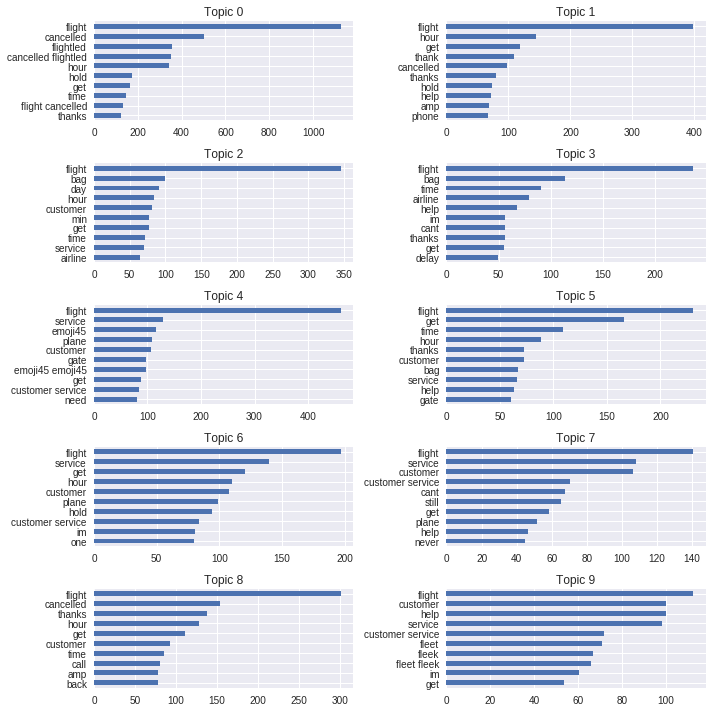

In [90]:
# All classes corpus.
file2save_model = data_out_dir+'LDASKL_model_all_classes_corpus.obj'
file2saveVectorizer = data_out_dir+'CV_all_classes_corpus.obj'
file2saveTopicPlot = img_out_dir+'TopicPlot_all_classes_corpus'
plot_title = "LDA topics for data: from all classes"
LDA_diff_corpuses(air_df['lemma_stopw_clean_text'], file2save_model, file2saveVectorizer, file2saveTopicPlot)

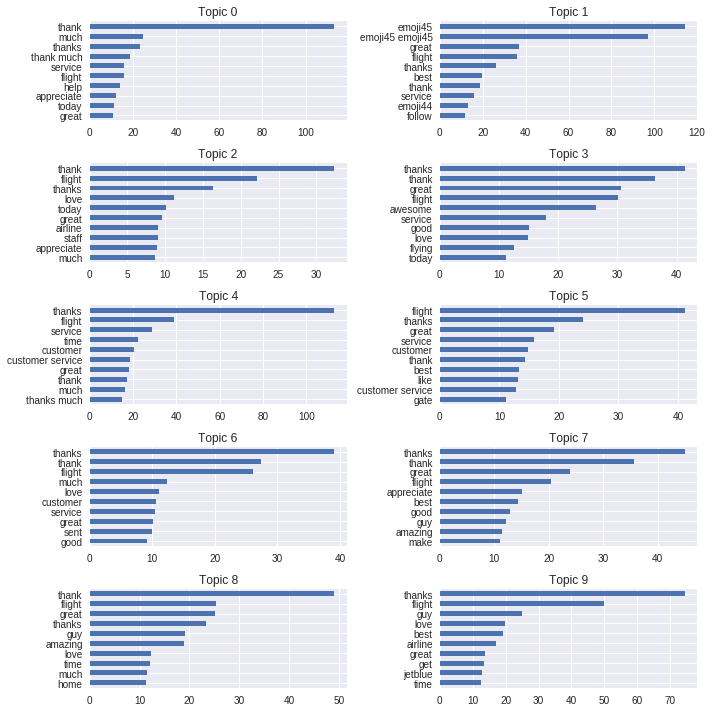

In [91]:
# Positive classe corpus.
corpus = air_df['lemma_stopw_clean_text'][air_df.airline_sentiment=='positive']
file2save_model = data_out_dir+'LDASKL_model_positive_class_corpus.obj'
file2saveVectorizer = data_out_dir+'CV_positive_class_corpus.obj'
file2saveTopicPlot = img_out_dir+'TopicPlot_positive_class_corpus'
LDA_diff_corpuses(corpus, file2save_model, file2saveVectorizer, file2saveTopicPlot)

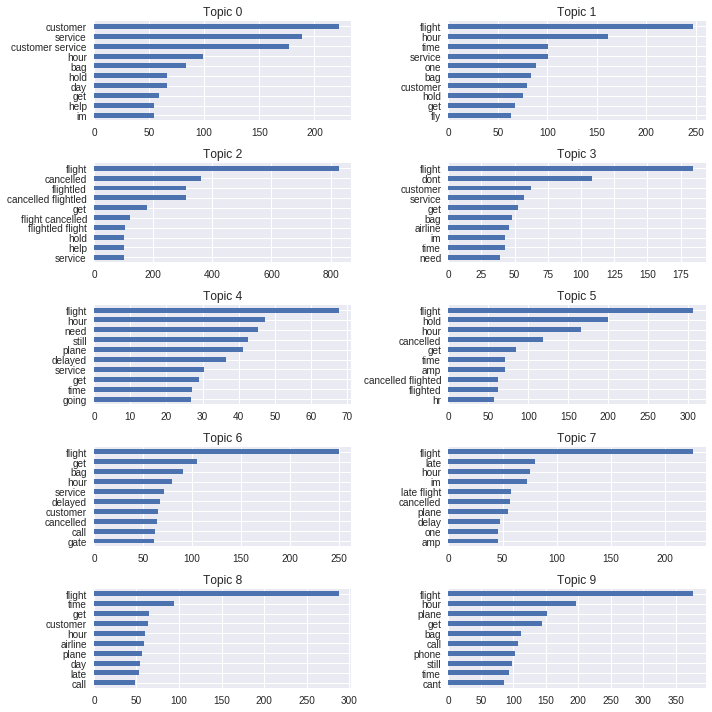

In [92]:
# Negative classe corpus.
corpus = air_df['lemma_stopw_clean_text'][air_df.airline_sentiment=='negative']
file2save_model = data_out_dir+'LDASKL_model_negative_class_corpus.obj'
file2saveVectorizer = data_out_dir+'CV_negative_class_corpus.obj'
file2saveTopicPlot = img_out_dir+'TopicPlot_negative_classe_corpus'
LDA_diff_corpuses(corpus, file2save_model, file2saveVectorizer, file2saveTopicPlot)

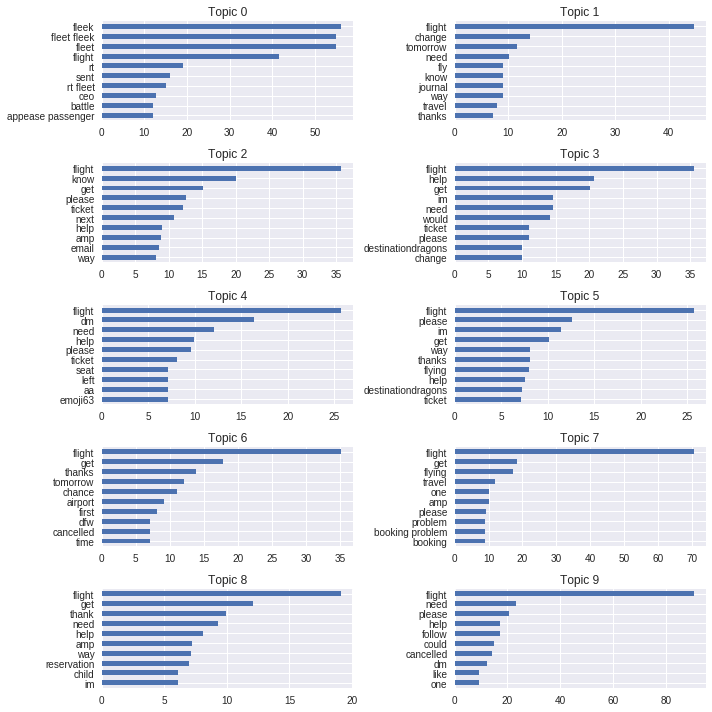

In [93]:
# Neutral classe corpus.
corpus = air_df['lemma_stopw_clean_text'][air_df.airline_sentiment=='neutral']
file2save_model = data_out_dir+'LDASKL_model_neutral_class_corpus.obj'
file2saveVectorizer = data_out_dir+'CV_neutral_class_corpus.obj'
file2saveTopicPlot = img_out_dir+'TopicPlot_neutral_class_corpus'
LDA_diff_corpuses(corpus, file2save_model, file2saveVectorizer, file2saveTopicPlot)

## Let's display topics by document (text, tweet...)

In [101]:
# read in pickled models.
lDA_model_allcl = gu.read_pickle_obj(data_out_dir+'LDASKL_model_all_classes_corpus.obj')
vect_allcl = gu.read_pickle_obj(data_out_dir+'CV_all_classes_corpus.obj')

lDA_model_pos = gu.read_pickle_obj(data_out_dir+'LDASKL_model_positive_class_corpus.obj')
vect_pos = gu.read_pickle_obj(data_out_dir+'CV_positive_class_corpus.obj')

lDA_model_neg = gu.read_pickle_obj(data_out_dir+'LDASKL_model_negative_class_corpus.obj')
vect_neg = gu.read_pickle_obj(data_out_dir+'CV_negative_class_corpus.obj')

lDA_model_net = gu.read_pickle_obj(data_out_dir+'LDASKL_model_neutral_class_corpus.obj')
vect_neut = gu.read_pickle_obj(data_out_dir+'CV_neutral_class_corpus.obj')

In [102]:
# all classes data.

In [ ]:
cleaned_corpus = air_df['lemma_stopw_clean_text']
dtm = vect_allcl.transform(cleaned_corpus)
comp = lDA_model_allcl.transform(test2)

In [123]:
document_topics = pd.DataFrame(comp, columns=["topic %d" % i for i in range(comp.shape[1])])
document_topics.head(5)

topic 0   topic 1   topic 2   topic 3   topic 4   topic 5   topic 6  \
0  0.050006  0.050009  0.050009  0.050012  0.050006  0.549939  0.050008   
1  0.005001  0.005000  0.954994  0.005001  0.005000  0.005001  0.005000   
2  0.012501  0.012501  0.012502  0.012501  0.012501  0.012502  0.887486   
3  0.003847  0.003847  0.965379  0.003847  0.003847  0.003847  0.003847   
4  0.008335  0.924987  0.008335  0.008335  0.008335  0.008335  0.008335   

    topic 7   topic 8   topic 9  
0  0.050004  0.050003  0.050004  
1  0.005000  0.005001  0.005001  
2  0.012502  0.012501  0.012502  
3  0.003847  0.003847  0.003847  
4  0.008334  0.008335  0.008334

## Let's take a look at the highest rated topic 0 documents¶

In [119]:
top_topics = document_topics['topic 0'] > .8
top_docs_topic_0 = document_topics[top_topics]
top_docs_topic_0.head(5)

topic 0   topic 1   topic 2   topic 3   topic 4   topic 5   topic 6  \
27  0.962496  0.004167  0.004167  0.004167  0.004167  0.004167  0.004167   
32  0.887479  0.012502  0.012503  0.012503  0.012502  0.012502  0.012502   
42  0.943745  0.006251  0.006251  0.006250  0.006250  0.006251  0.006251   
64  0.959085  0.004546  0.004546  0.004546  0.004546  0.004546  0.004547   
80  0.959086  0.004546  0.004546  0.004546  0.004546  0.004546  0.004546   

     topic 7   topic 8   topic 9  
27  0.004167  0.004167  0.004167  
32  0.012501  0.012503  0.012502  
42  0.006250  0.006251  0.006250  
64  0.004546  0.004546  0.004546  
80  0.004546  0.004546  0.004546

In [121]:
cleaned_corpus[top_docs_topic_0.index.values[:10]]

27     plz help win bid upgrade flight 227 laxgtsea e...
32                                wish flew atlanta soon
42     heyyyy guyyyys trying get hour someone call pl...
64     website btw new website isnt great user experi...
80     beautiful frontend design right cool still boo...
93           another delayed flight likingyoulessandless
118    normal receive reply central baggage baggageis...
120                             jump dallasaustin market
123             begin dallasaustin flight april 889 ketr
124    congrats got business ewr sfolax fuck fl1289 s...
Name: lemma_stopw_clean_text, dtype: object

## Let's check out the documents within the source content¶

In [124]:
top_documents = top_docs_topic_0.index.values
cleaned_corpus[top_documents].head(10)

27     plz help win bid upgrade flight 227 laxgtsea e...
32                                wish flew atlanta soon
42     heyyyy guyyyys trying get hour someone call pl...
64     website btw new website isnt great user experi...
80     beautiful frontend design right cool still boo...
93           another delayed flight likingyoulessandless
118    normal receive reply central baggage baggageis...
120                             jump dallasaustin market
123             begin dallasaustin flight april 889 ketr
124    congrats got business ewr sfolax fuck fl1289 s...
Name: lemma_stopw_clean_text, dtype: object

In [ ]:
# Note: In sklearn we get pseudocounts. In Gensim, we get probabilities.

In [ ]:
# Credits: Dave's LDA lesson.

In [ ]:
# I can cotinue to look into this and study it with unclassified data.
# pull tweets, use unsupervised learning method LDA, to identify topics within the corpus of tweets.